In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from glob import glob
import random
from tqdm.auto import tqdm

In [2]:
from IPython.display import Image
from IPython.core.display import HTML

In [3]:
os.chdir('../')
sns.set(style='whitegrid', palette='Set1')

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
from tools.analyze_logs import load_json_logs

# Read logs

In [6]:
WORK_DIR = '/home/darynarr/university/diploma/MI-AOD/work_dirs/MI-AOD/'
LOG_TS = '20220422_201426'
JSON_LOG = os.path.join(WORK_DIR, LOG_TS, LOG_TS + '.log.json')

In [7]:
for log_path in glob(WORK_DIR+'*/', recursive = True):
    if 'cycle6' in os.listdir(log_path):
        print(log_path)

/home/darynarr/university/diploma/MI-AOD/work_dirs/MI-AOD/20220422_201426/
/home/darynarr/university/diploma/MI-AOD/work_dirs/MI-AOD/20220429_183416/
/home/darynarr/university/diploma/MI-AOD/work_dirs/MI-AOD/20220426_164853/
/home/darynarr/university/diploma/MI-AOD/work_dirs/MI-AOD/20220416_152637/


In [8]:
researches_mapping = {
    '20220429_183416': 'l1_norm (original)',
    '20220426_164853': 'kl_divergence',
    '20220416_152637': 'cross_entropy'
}

In [9]:
def read_json_logs(json_log_path):
    logs = []
    train_logs = []
    val_logs = []
    with open(json_log_path, 'r') as log_file:
        for line in log_file:
            log = json.loads(line.strip())
            log['log_name'] = json_log_path.split('work_dirs/MI-AOD/')[-1].split('/')[0]
            logs.append(log)
            if 'mode' in log.keys():
                if log['mode'] == 'train':
                    train_logs.append(log)
                elif log['mode'] == 'val':
                    val_logs.append(log)
    return logs, train_logs, val_logs

## Different distance results

## L1 loss (used in paper)

In [44]:
Image(url='https://miro.medium.com/max/630/1*OVlFLnMwHDx08PHzqlBDag.gif', height=100, width=300)

## Binary Cross-entropy / Log Loss

In [11]:
Image(url= "http://androidkt.com/wp-content/uploads/2021/05/Selection_099-1024x200.png", height=100, width=700)

## Kullback–Leibler (KL) divergence

In [12]:
Image(url= "https://miro.medium.com/max/566/1*pqnS3f2aWcKSFqfXxx75JQ.png", height=100, width=400)

In [13]:
logs = []
train_logs = []
val_logs = []
for log_name in researches_mapping.keys():
    json_log_path = os.path.join(WORK_DIR, log_name, log_name + '.log.json')
    l, t_l, v_l = read_json_logs(json_log_path)
    logs.extend(l)
    train_logs.extend(t_l)
    val_logs.extend(v_l)
df_train_logs = pd.DataFrame(train_logs)
df_train_logs['log_name'] = df_train_logs['log_name'].map(researches_mapping)
df_val_logs = pd.DataFrame(val_logs)
df_val_logs['log_name'] = df_val_logs['log_name'].map(researches_mapping)

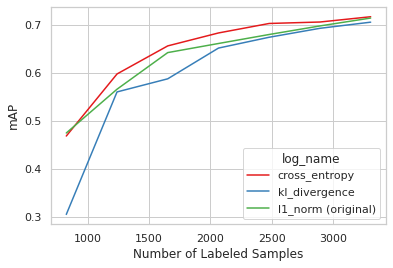

In [14]:
df_val_logs.pivot(index='iter', values='mAP', columns='log_name').plot(ylabel='mAP', xlabel='Number of Labeled Samples');

In [15]:
df_val_logs.pivot(index='iter', values='mAP', columns='log_name')

log_name,cross_entropy,kl_divergence,l1_norm (original)
iter,,,
827,0.46891,0.30570,0.47525
1240,0.59817,0.56077,0.56642
1653,0.65664,0.58810,0.64269
2066,0.68357,0.65210,0.66163
2479,0.70334,0.67465,0.68039
2892,0.70636,0.69326,0.69820
3305,0.71734,0.70604,0.71463


In [16]:
n_train_samples = (5011 + 11540)
df_val_logs['pct_labeled_samples'] = np.round(df_val_logs['iter'] / n_train_samples, 3)
df_val_logs.pivot(index='pct_labeled_samples', values='mAP', columns='log_name')

log_name,cross_entropy,kl_divergence,l1_norm (original)
pct_labeled_samples,,,
0.050,0.46891,0.30570,0.47525
0.075,0.59817,0.56077,0.56642
0.100,0.65664,0.58810,0.64269
0.125,0.68357,0.65210,0.66163
0.150,0.70334,0.67465,0.68039
0.175,0.70636,0.69326,0.69820
0.200,0.71734,0.70604,0.71463


# Check model for filtering blurred images

In [17]:
import cv2
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from mmdet.apis.inference import *

In [18]:
DATA_DIR = '/home/darynarr/university/diploma/MI-AOD/data/VOCdevkit/'

## Read model and prepare train/test sets images split

In [19]:
model = init_detector(
        './configs/MIAOD.py', checkpoint=os.path.join(WORK_DIR, '20220422_201426/epoch_3.pth'), device='cuda:0')

In [20]:
train_images_names = dict()
test_images_names = dict()

datasets_names = ['VOC2007', 'VOC2012']

for dataset_name in datasets_names:
    train_list_path = os.path.join(DATA_DIR, f'{dataset_name}/ImageSets/Main/trainval.txt')
    
    with open(train_list_path, 'r') as f:
        train_images_names[dataset_name] = [line.strip() for line in f]
        
    if dataset_name == 'VOC2012': # no test set for VOC2012
        continue
    test_list_path = os.path.join(DATA_DIR, f'{dataset_name}/ImageSets/Main/test.txt')
    with open(test_list_path, 'r') as f:
        test_images_names[dataset_name] = [line.strip() for line in f]
        
df_train_images = pd.concat({k: pd.Series(v) for k, v in train_images_names.items()}).reset_index()
df_test_images = pd.concat({k: pd.Series(v) for k, v in test_images_names.items()}).reset_index()
df_train_images['is_test'] = 0
df_test_images['is_test'] = 1

df_images = pd.concat([df_train_images, df_test_images])
df_images = df_images.rename(columns={'level_0': 'dataset', 0: 'image_name'})
df_images = df_images.drop('level_1', axis=1)

In [21]:
df_images_all = df_images.copy()
df_images = df_images[~((df_images['dataset'] == 'VOC2007') & (df_images['is_test'] == 0))]
df_images = df_images.reset_index(drop=True)

In [22]:
df_images.sample(20)

,dataset,image_name,is_test
3015,VOC2012,2008_006088,0
9912,VOC2012,2010_005721,0
11766,VOC2007,000444,1
6973,VOC2012,2009_005153,0
15394,VOC2007,007780,1
13999,VOC2007,004922,1
700,VOC2012,2008_001429,0
13190,VOC2007,003324,1
14354,VOC2007,005651,1
16412,VOC2007,009804,1


## Images blurring
Blur images in train and test sets. 
50% of the images are blurred with Gaussian blur with different factor (inverse of strength). 50% of the images are left as they are.

In [23]:
def apply_blur(img, factor=3.):
    (h, w) = img.shape[:2]
    kW = int(w / factor)
    kH = int(h / factor)
    # ensure the width of the kernel is odd
    if kW % 2 == 0:
        kW -= 1
    # ensure the height of the kernel is odd
    if kH % 2 == 0:
        kH -= 1
    blurred_img = cv2.GaussianBlur(img, (kW, kH), 0)
    # out = np.where(mask, blurred_img, img)
    # return out
    return blurred_img

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1080x360 with 0 Axes>

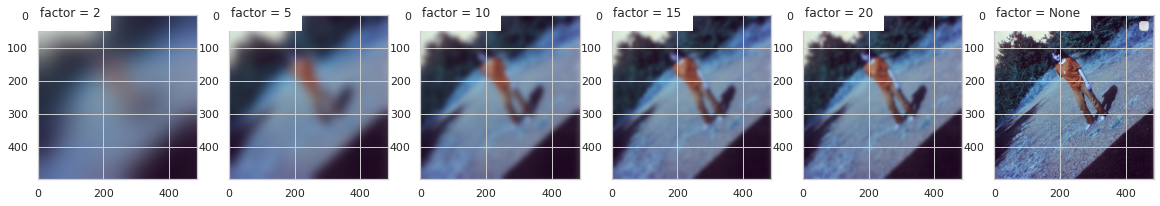

In [24]:
factors = [2, 5, 10, 15, 20] + [None]

plt.figure(figsize=(15, 5))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, len(factors), figsize=(20, 20)) 


for i, factor in enumerate(factors):
    results = {'img': os.path.join(DATA_DIR, 'VOC2012/JPEGImages/2007_000027.jpg')}

    img_loader = LoadImage()
    img = img_loader(results)
    if factor is not None:
        img['img'] = apply_blur(img['img'], factor)
    # res = inference_detector(model, img['img'])
    # uncertainty = res[1].cpu().numpy().item()
    axarr[i].imshow(img['img'])
    axarr[i].text(5, 5, f'factor = {factor}', bbox={'facecolor': 'white', 'pad': 10})

plt.legend()
plt.show()
plt.close()

In [25]:
df_images['is_blurred'] = random.choices([0, 1], weights=(1, 1), k=df_images.shape[0])
df_images['factor'] = np.nan
df_images.loc[df_images['is_blurred'] == 1, 'factor'] = random.choices([2, 5, 10, 15, 20], k=sum(df_images['is_blurred'] == 1))

df_images.groupby(['is_test', 'is_blurred', 'factor'], dropna=False).size()

is_test  is_blurred  factor
0        0           NaN       5780
         1           2.0       1181
                     5.0       1097
                     10.0      1169
                     15.0      1128
                     20.0      1185
1        0           NaN       2432
         1           2.0        537
                     5.0        523
                     10.0       493
                     15.0       507
                     20.0       460
dtype: int64

In [26]:
df_images.groupby('is_test').size()

is_test
0    11540
1     4952
dtype: int64

## Calculate uncertainty for blurred/clear images

In [27]:
df_images['uncertainty'] = np.nan
for i, row in tqdm(df_images.iterrows(), total=df_images.shape[0]):
    results = {'img': os.path.join(DATA_DIR, f'{row["dataset"]}/JPEGImages/{row["image_name"]}.jpg')}
    img_loader = LoadImage()
    img = img_loader(results)
    if row['is_blurred']:
        img['img'] = apply_blur(img['img'], row['factor'])
    res = inference_detector(model, img['img'])
    uncertainty = res[1].cpu().numpy().item()
    df_images.loc[i, 'uncertainty'] = uncertainty

  0%|          | 0/16492 [00:00<?, ?it/s]

/home/darynarr/university/diploma/MI-AOD/mmdet/core/post_processing/bbox_nms.py:52: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  labels = valid_mask.nonzero()[:, 1]


In [28]:
train_mask = (df_images['is_test'] == 0)
test_mask = (df_images['is_test'] == 1)
blur_mask = df_images['is_blurred'] == 1

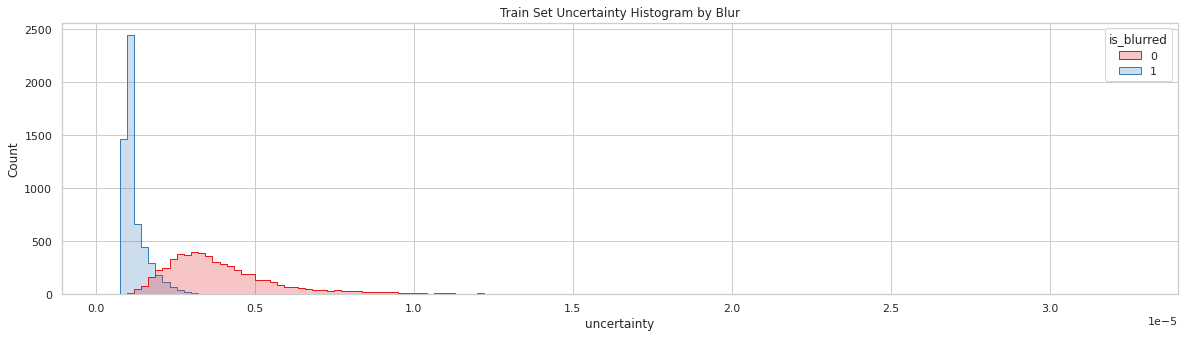

In [29]:
plt.figure(figsize=(20, 5))

sns.histplot(df_images[train_mask], x="uncertainty", hue="is_blurred",  element="step")
plt.title('Train Set Uncertainty Histogram by Blur');

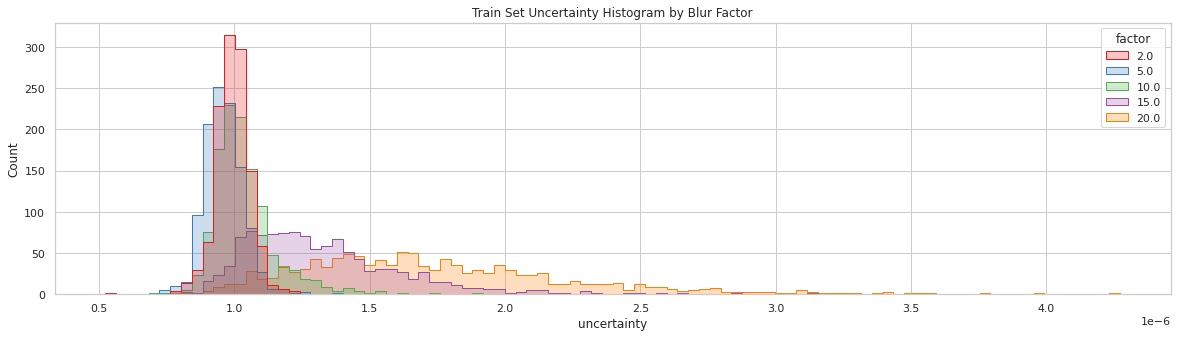

In [30]:
plt.figure(figsize=(20, 5))
sns.histplot(
    df_images[train_mask & blur_mask], x="uncertainty", hue="factor",  element="step", palette='Set1')
plt.title('Train Set Uncertainty Histogram by Blur Factor');

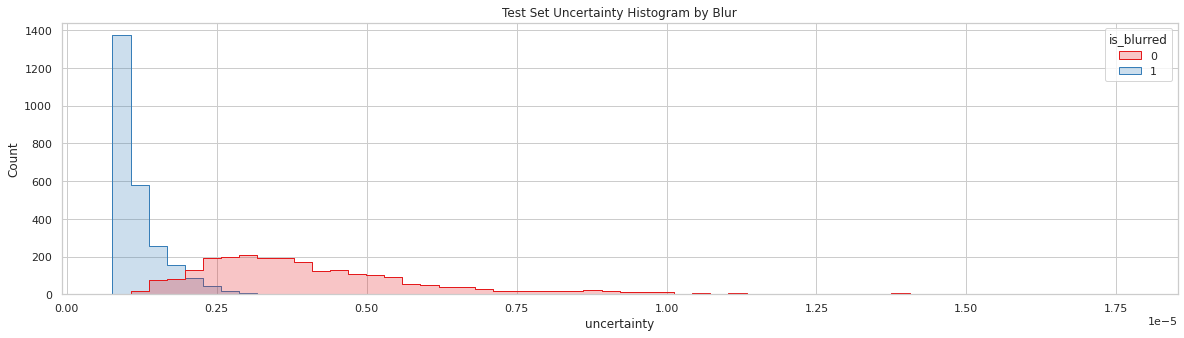

In [31]:
plt.figure(figsize=(20, 5))

sns.histplot(df_images[test_mask], x="uncertainty", hue="is_blurred",  element="step")
plt.title('Test Set Uncertainty Histogram by Blur');

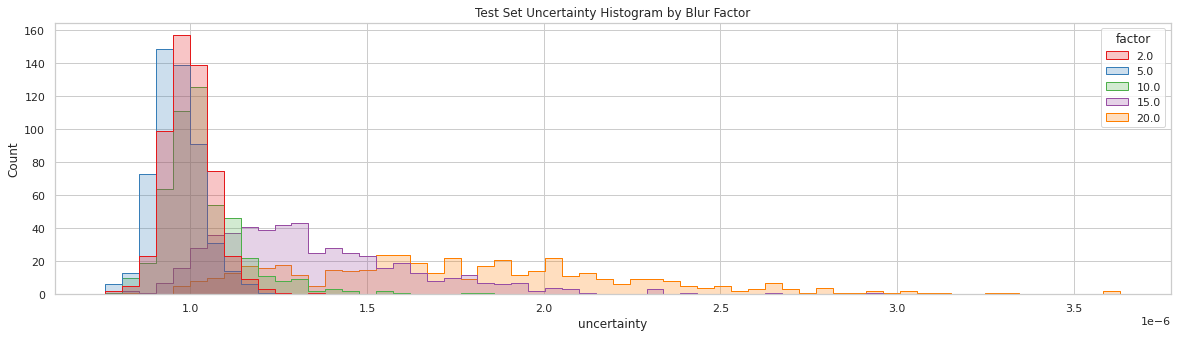

In [32]:
plt.figure(figsize=(20, 5))
sns.histplot(
    df_images[test_mask & blur_mask], x="uncertainty", hue="factor",  element="step", palette='Set1')
plt.title('Test Set Uncertainty Histogram by Blur Factor');

## Analyze the results
Find best uncertainty threshold based on the train set results using precision-recall curve. Analyze the results for both train and test.

Accuracy 0.9354419410745234
Precision 0.9273468002037005
Recall 0.9451557093425605
F1-score 0.9361665667037957


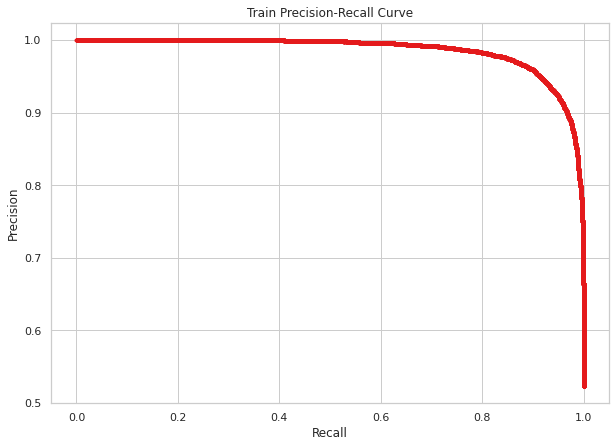

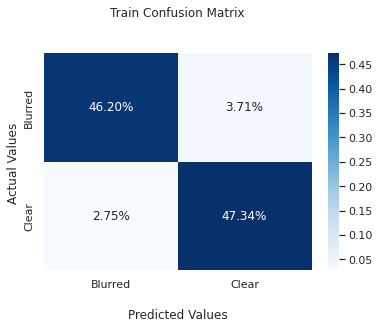

In [33]:
precision, recall, thresholds = precision_recall_curve(
    (df_images[train_mask ]['is_blurred'] == False).astype(int), 
    df_images[train_mask]['uncertainty'])

dist_from_11 = [(1 - p)**2 + (1-q)**2 for p, q in zip(precision, recall)]
best_threshold = thresholds[np.array(dist_from_11).argmin()]

y_true = (df_images[train_mask]['is_blurred']==0).astype(int)
y_pred = (df_images[train_mask]['uncertainty'] > best_threshold).astype(int)

print('Accuracy', accuracy_score(y_true, y_pred))
print('Precision', precision_score(y_true, y_pred))
print('Recall', recall_score(y_true, y_pred))
print('F1-score', f1_score(y_true, y_pred))

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.')

# baseline = sum(train_mask & (~blur_mask)) / sum(train_mask)
plt.title('Train Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall');
plt.show()
plt.close()

train_conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(train_conf_matrix/ np.sum(train_conf_matrix), annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Train Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Blurred','Clear'])
ax.yaxis.set_ticklabels(['Blurred','Clear'])

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy 0.9301292407108239
Precision 0.9212439418416801
Recall 0.9379111842105263
F1-score 0.9295028524857377


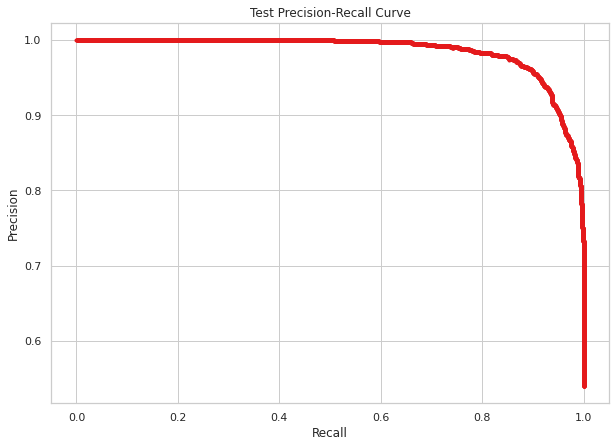

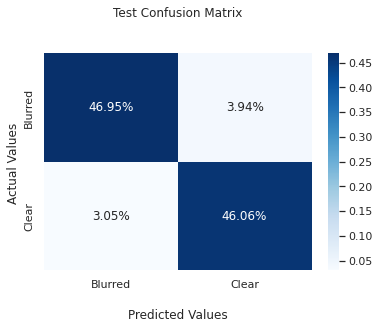

In [34]:
precision, recall, thresholds = precision_recall_curve((df_images[test_mask]['is_blurred'] == False).astype(int), df_images[test_mask]['uncertainty'])

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.')
y_true = (df_images[test_mask]['is_blurred']==0).astype(int)
y_pred = (df_images[test_mask]['uncertainty'] > best_threshold).astype(int)
print('Accuracy', accuracy_score(y_true, y_pred))
print('Precision', precision_score(y_true, y_pred))
print('Recall', recall_score(y_true, y_pred))
print('F1-score', f1_score(y_true, y_pred))
baseline = sum(test_mask & (~blur_mask)) / sum(test_mask)
plt.title('Test Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall');
plt.show()
plt.close()

test_conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(test_conf_matrix/ np.sum(test_conf_matrix), annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Test Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Blurred','Clear'])
ax.yaxis.set_ticklabels(['Blurred','Clear'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Some examples of correctly/wrongly classified images

In [35]:
df_images['pred_is_blurred'] = (df_images['uncertainty'] <= best_threshold).astype(int)

### Incorrectly classified images

There are a lot of wrongly classified images among blurred images with high factor (low strength of blur) - that's probably because the quality of the picture is still good enough to recognize something.

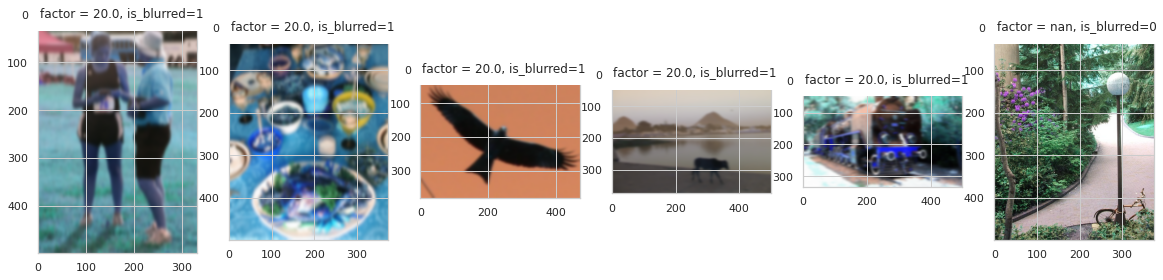

In [40]:
n_samples = 6
f, axarr = plt.subplots(1, 6, figsize=(20, 20)) 
for i, row in df_images[test_mask & (df_images['is_blurred'] != df_images['pred_is_blurred'])].sample(n_samples).reset_index(drop=True).iterrows():
    results = {'img': os.path.join(DATA_DIR, f'{row["dataset"]}/JPEGImages/{row["image_name"]}.jpg')}
    img_loader = LoadImage()
    img = img_loader(results)
    factor = row['factor']
    if not np.isnan(factor):
        img['img'] = apply_blur(img['img'], factor)
    # res = inference_detector(model, img['img'])
    # uncertainty = res[1].cpu().numpy().item()
    axarr[i].imshow(img['img'])
    axarr[i].text(5, 5, f'factor = {factor}, is_blurred={row["is_blurred"]}', bbox={'facecolor': 'white', 'pad': 10})

### Correctly classified images

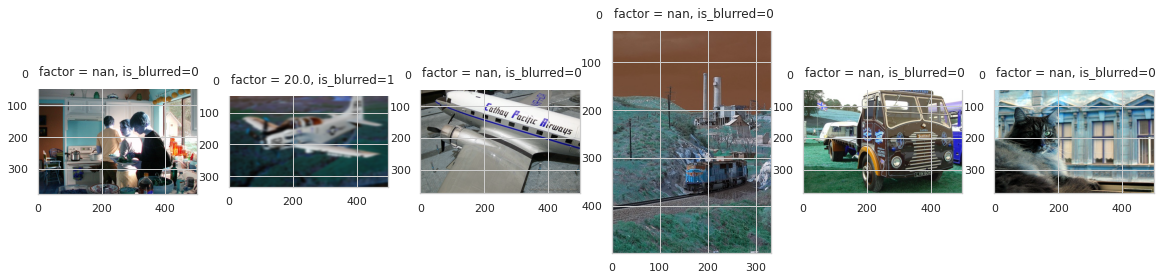

In [41]:
n_samples = 6
f, axarr = plt.subplots(1, 6, figsize=(20, 20)) 
for i, row in df_images[test_mask & (df_images['is_blurred'] == df_images['pred_is_blurred'])].sample(n_samples).reset_index(drop=True).iterrows():
    results = {'img': os.path.join(DATA_DIR, f'{row["dataset"]}/JPEGImages/{row["image_name"]}.jpg')}
    img_loader = LoadImage()
    img = img_loader(results)
    factor = row['factor']
    if not np.isnan(factor):
        img['img'] = apply_blur(img['img'], factor)
    # res = inference_detector(model, img['img'])
    # uncertainty = res[1].cpu().numpy().item()
    axarr[i].imshow(img['img'])
    axarr[i].text(5, 5, f'factor = {factor}, is_blurred={row["is_blurred"]}', bbox={'facecolor': 'white', 'pad': 10})